In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPProcessor, CLIPModel, pipeline
import ollama

/home/luchocode/miniconda3/envs/ve-tesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Load the free model (Small and fast)
model_id = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

# 2. Define your ExoNet Labels (The Prompts)
# Trick: Use sentences, not just words, for better accuracy.
labels = [
    "a photo of flat level ground",
    "a photo looking up at a staircase",
    "a photo looking down a staircase",
    "a photo of a closed door",
    "a photo of a wall obstacle",
    "a photo of a cluttered floor with obstacles"
]

def auto_tag_image(image_path):
    image = Image.open(image_path)
    
    # Process inputs
    inputs = processor(text=labels, images=image, return_tensors="pt", padding=True)
    
    # Run Inference
    with torch.no_grad():
        outputs = model(**inputs)
        
    # Calculate probabilities
    probs = outputs.logits_per_image.softmax(dim=1)
    
    # Get the winner
    best_idx = probs.argmax()
    best_label = labels[best_idx]
    confidence = probs[0][best_idx].item()
    
    return best_label, confidence

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [12]:
# Usage
img_path = "/media/luchocode/Extra vol/thesis/data/selected_exoimages/val/DW-T-O/['IMG_03_4'] frame 44628.jpg"
label, conf = auto_tag_image(img_path)
print(f"Predicted: {label} ({conf:.1%})")

Predicted: a photo of a closed door (28.8%)


In [3]:
response = ollama.chat(model='llava', messages=[
  {
    'role': 'user',
    'content': 'Look at this image. Is the user walking on flat ground, or approaching stairs? Respond with only one word: Ground, Stairs, or Door.',
    'images': ["/media/luchocode/Extra vol/thesis/data/selected_exoimages/val/LG-T-DW/['IMG_03_4'] frame 12.jpg"]
  }
])

print(response['message']['content'])

 Flat ground 


# Use depth estimator

In [14]:
# --- 1. SETUP DEPTH MODEL (The Geometric Eye) ---
# 'depth-anything' is excellent for varying terrains
depth_estimator = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf", use_fast=True)

def get_distance_heuristic(image):
    """
    Returns an estimated 'closeness' score (0 to 1).
    Real distance requires calibration, but relative closeness is enough for transitions.
    """
    # 1. Get depth map
    depth_output = depth_estimator(image)
    depth_map = np.array(depth_output["depth"])
    
    # 2. Focus on the Center-Bottom (where feet/stairs appear)
    h, w = depth_map.shape
    center_crop = depth_map[int(h/2):h, int(w/3):int(w*2/3)]
    img_center_crop = np.array(image)[int(h/2):h, int(w/3):int(w*2/3)]
    # print(img_center_crop)
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(image.convert("RGB"))
    ax[1].imshow(img_center_crop)
    
    # 3. Calculate average brightness (Brighter = Closer in most depth maps)
    # Note: Check model docs; usually High Value = Close for 'inverse depth'
    avg_closeness = np.mean(center_crop)
    
    # Normalize to 0-1 range roughly (assuming 255 max)
    normalized_score = avg_closeness / 255.0
    print(f"Normalized score: {normalized_score}")
    return normalized_score

# --- 2. SETUP LLaVA (The Semantic Brain) ---
def get_semantic_label(image_path):
    response = ollama.chat(model='llava', messages=[
        {
            'role': 'user',
            'content': 'Describe the terrain directly ahead. Is it Level Ground, Incline Stairs, Decline Stairs, or a Door? Return only the label.',
            'images': [image_path]
        }
    ])
    return response['message']['content'].strip()

# --- 3. THE FUSION LOGIC ---
def classify_frame_with_fusion(image_path):
    image = Image.open(image_path)
    
    # Run Parallel Inference
    label, conf = auto_tag_image(img_path)
    semantic_label = get_semantic_label(image_path)
    closeness_score = get_distance_heuristic(image)
    
    print(label, conf)
    print(f"Vision says: {semantic_label}")
    print(f"Depth Score: {closeness_score:.2f}") # e.g., 0.8 is very close, 0.2 is far
    
    # DEFINE YOUR "TRANSITION" THRESHOLD
    TRANSITION_THRESHOLD = 0.75  # You must tune this value experimentally
    
    final_label = "Unknown"
    
    # Logic Tree matching ExoNet
    if "Stairs" in semantic_label:
        if closeness_score > TRANSITION_THRESHOLD:
            final_label = "LG-T-IS (Approaching Stairs)"
        else:
            final_label = "LG (Seeing Stairs, but too far)"
            
    elif "Door" in semantic_label:
        if closeness_score > TRANSITION_THRESHOLD:
            final_label = "LG-T-DW (Approaching Door)"
        else:
            final_label = "LG (Seeing Door, but too far)"
            
    elif "Ground" in semantic_label:
        final_label = "LG-S (Steady Ground)"
        
    return final_label

Device set to use cuda:0


Normalized score: 0.5001920731862873
a photo of a closed door 0.28825467824935913
Vision says: Incline Stairs
Depth Score: 0.50
FINAL TAG: LG (Seeing Stairs, but too far)


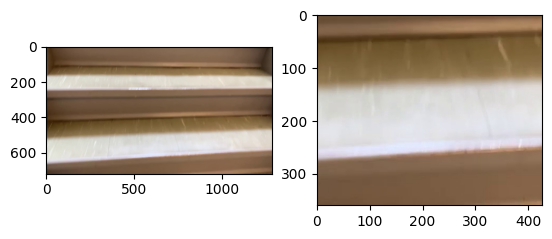

In [19]:
# --- Usage ---
result = classify_frame_with_fusion("/media/luchocode/Extra vol/thesis/data/selected_exoimages/val/IS-S/['IMG_03_4'] frame 2658.jpg")
print(f"FINAL TAG: {result}")